In [0]:
from attention import AttentionLayer

In [0]:
# !pip install nltk

In [3]:
pip install rogue

  Created wheel for rogue: filename=rogue-0.0.2-cp36-none-any.whl size=7213 sha256=90aed01ed6ba237f481c4a0291c29ac367d9efeb8b2cdb3e19280b496da9de17
  Stored in directory: /root/.cache/pip/wheels/02/39/20/d62d788c77e226459e17e14df0d04aa5e48ef87d1e05cd06e5
Successfully built rogue


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
data=pd.read_csv("Reviews.csv",nrows=100000)

In [0]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [0]:
# removal of stop words
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [0]:
# store preprocessed data
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [0]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

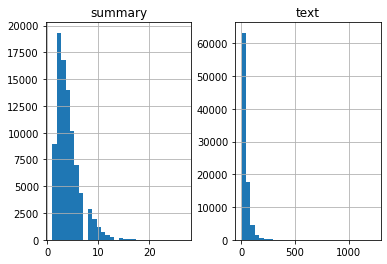

In [14]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [0]:
# update the sequence length
max_text_len=40
max_summary_len=27

# max_text_len=30
# max_summary_len=8


In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [0]:
# adding tokens beginning and end of summary
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
# split dataset in train and validation dataset
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [21]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.1652043445644
Total Coverage of rare words: 2.3446210452007614


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [0]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.14233173961014
Total Coverage of rare words: 4.667984857367129


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(54424, 54424)

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [44]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1,*_ = encoder_lstm1(enc_emb)

#encoder bi-lstm 2. In case of unidirectional encoder remove the parameter go_backwards = True
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)
encoder_output2, state_h2, state_c2,*_ = encoder_lstm2(encoder_output1)

#encoder bi-lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)
encoder_outputs, state_h, state_c,*_= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      1068100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
# Loss function sparse_categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
# early stopping. monitoring on validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [47]:
# batch size = 512
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 53290 samples, validate on 5908 samples
Epoch 1/50
53290/53290 [==============================] - 105s 2ms/sample - loss: 0.9026 - val_loss: 0.7890
Epoch 2/50
53290/53290 [==============================] - 103s 2ms/sample - loss: 0.7752 - val_loss: 0.7460
Epoch 3/50
53290/53290 [==============================] - 101s 2ms/sample - loss: 0.7360 - val_loss: 0.7133
Epoch 4/50
53290/53290 [==============================] - 101s 2ms/sample - loss: 0.7102 - val_loss: 0.6941
Epoch 5/50
53290/53290 [==============================] - 102s 2ms/sample - loss: 0.6905 - val_loss: 0.6816
Epoch 6/50
53290/53290 [==============================] - 102s 2ms/sample - loss: 0.6755 - val_loss: 0.6752
Epoch 7/50
53290/53290 [==============================] - 103s 2ms/sample - loss: 0.6629 - val_loss: 0.6635
Epoch 8/50
53290/53290 [==============================] - 103s 2ms/sample - loss: 0.6528 - val_loss: 0.6581
Epoch 9/50
53290/53290 [==============================] - 103s 2ms/sample - loss: 0.643

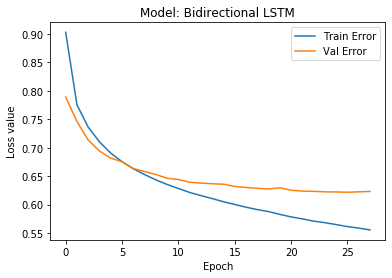

In [61]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Train Error')
pyplot.plot(history.history['val_loss'], label='Val Error')
pyplot.title('Model: Bidirectional LSTM')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss value')
pyplot.legend()
pyplot.show()

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Unidirectional Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [53]:
# printing review, original summary and predicted summary
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: tea morning time savior coffee drinker tried hate jitters family indian blood tea tastes like smell amazing enjoyed straight little bit milk sugar 
Original summary: if the fall season had taste 
Predicted summary:  great tea


Review: mix easy add water taste hearty good makes outstanding waffles family great size open bag put mix metal cannister keep fresh 
Original summary: great waffles 
Predicted summary:  great product


Review: pleased expensive worth cost beautiful soft luster adds baked goods shaker pour easy application ordering 
Original summary: for the kitchen 
Predicted summary:  great product


Review: cookies really good husband grandkids gluten free love 
Original summary: great 
Predicted summary:  great cookies


Review: description item wrong contain msg monosodium glutamate also contains preservatives item called natural 
Original summary: the item contains msg 
Predicted summary:  not bad


Review: received item product good however item less grocery thoug

In [54]:
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,sostok delight says it all eostok
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok


In [55]:
pip install rouge

Rouge metric to evaluate Training set

In [62]:
from rouge import Rouge 
r1 = 0.0
r2 = 0.0
rl = 0.0
rouge = Rouge()

size = x_tr.shape[0]

for i in range(0,size):
    try:
      score = rouge.get_scores(decode_sequence(x_tr[i].reshape(1,max_text_len)), seq2summary(y_tr[i]))
    except:
      continue

    r1+= score[0]['rouge-1']['f']
    r2+= score[0]['rouge-2']['f']
    rl+= score[0]['rouge-l']['f']

# Calculating average score of Rouge-1, Rouge-2, Rouge-L
print("Rouge-1 : {0}".format(r1/size))
print("Rouge-2 : {0}".format(r2/size))
print("Rouge-L : {0}".format(rl/size))

Rouge-1 : 0.1470461321739418
Rouge-2 : 0.03231330445969857
Rouge-L : 0.13236437103233467


Finding Rouge score of test data (5000 records)


In [0]:
def cal_test_data_rogue(test_data):
  test_data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
  test_data.dropna(axis=0,inplace=True)#dropping na

  #call the function
  cleaned_test_text = []
  for t in test_data['Text']:
      cleaned_test_text.append(text_cleaner(t,0))

  #call the function
  cleaned_test_summary = []
  for t in test_data['Summary']:
      cleaned_test_summary.append(text_cleaner(t,1))

  test_data['cleaned_text']=cleaned_test_text
  test_data['cleaned_summary']=cleaned_test_summary
  test_data.replace('', np.nan, inplace=True)
  test_data.dropna(axis=0,inplace=True)
  cleaned_test_text =np.array(test_data['cleaned_text'])
  cleaned_test_summary=np.array(test_data['cleaned_summary'])

  short_test_text=[]
  short_test_summary=[]

  for i in range(len(cleaned_test_text)):
      if(len(cleaned_test_summary[i].split())<=max_summary_len and len(cleaned_test_text[i].split())<=max_text_len):
          short_test_text.append(cleaned_test_text[i])
          short_test_summary.append(cleaned_test_summary[i])
          
  df_test=pd.DataFrame({'text':short_test_text,'summary':short_test_summary})

  df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

  x_test = np.array(df_test['text'])
  y_test = np.array(df_test['summary'])

  #convert text sequences into integer sequences
  x_test_seq    =   x_tokenizer.texts_to_sequences(x_test) 

  #padding zero upto maximum length
  x_test    =   pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')

  #convert text sequences into integer sequences
  y_test_seq    =   y_tokenizer.texts_to_sequences(y_test) 

  #padding zero upto maximum length
  y_test    =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

  from rouge import Rouge 
  r1 = 0.0
  r2 = 0.0
  rl = 0.0
  rouge = Rouge()

  size = x_test.shape[0]

  for i in range(0,size):
      try:
        score = rouge.get_scores(decode_sequence(x_test[i].reshape(1,max_text_len)), seq2summary(y_test[i]))
      except:
        continue

      r1+= score[0]['rouge-1']['f']
      r2+= score[0]['rouge-2']['f']
      rl+= score[0]['rouge-l']['f']

  # Calculating average score of Rouge-1, Rouge-2, Rouge-L
  print("Rouge-1 : {0}".format(r1/size))
  print("Rouge-2 : {0}".format(r2/size))
  print("Rouge-L : {0}".format(rl/size))
  print()
  for i in range(0,200):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")


In [58]:
test_data=pd.read_csv("Reviews.csv",skiprows=100001, nrows=5000,
                      names = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
cal_test_data_rogue(test_data)

Rouge-1 : 0.1368348516370101
Rouge-2 : 0.028525941149879736
Rouge-L : 0.12400868131779888

Review: taste great especially cook vegetable egg like much though expensive noodles 
Original summary: like it 
Predicted summary:  good stuff


Review: best instant noodle tried spicy yes like spicy always dilute water reduce strength make less salty 
Original summary: the best instant noodle 
Predicted summary:  good but not great


Review: see anyone could say anything bad noodles number one nong shim noodles great add egg green onion every good handful firm tofu enjoy eating nice hot cup bigelow earl grey green tea count boxes classic doctor 
Original summary: awesome 
Predicted summary:  not bad


Review: good noodles better ones find supermarket flavor real pretty spicy crazy hot right ok ok quick minute lunch job work 
Original summary: yummy fast 
Predicted summary:  not bad


Review: spicy packaged ramen good someone wants easy ramen wants something better cent beef ramen store best use

Finding Rouge score of test data (20000 records)

In [59]:
test_data=pd.read_csv("Reviews.csv",skiprows=100001, nrows=20000,
                      names = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
cal_test_data_rogue(test_data)

Rouge-1 : 0.1379074609543127
Rouge-2 : 0.02929424576013766
Rouge-L : 0.12451067660227615

Review: taste great especially cook vegetable egg like much though expensive noodles 
Original summary: like it 
Predicted summary:  good stuff


Review: best instant noodle tried spicy yes like spicy always dilute water reduce strength make less salty 
Original summary: the best instant noodle 
Predicted summary:  good but not great


Review: see anyone could say anything bad noodles number one nong shim noodles great add egg green onion every good handful firm tofu enjoy eating nice hot cup bigelow earl grey green tea count boxes classic doctor 
Original summary: awesome 
Predicted summary:  not bad


Review: good noodles better ones find supermarket flavor real pretty spicy crazy hot right ok ok quick minute lunch job work 
Original summary: yummy fast 
Predicted summary:  not bad


Review: spicy packaged ramen good someone wants easy ramen wants something better cent beef ramen store best use 